## Libraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install polars
!pip install japanize_matplotlib
!pip install statsmodels
!pip install scipy
!pip install sklearn
!pip install tqdm
!pip install linearmodels
!pip install rdrobust
!pip install rddensity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bc604bd07722b285c85264452017c02dcfb16a492f221b8ba4ea9d34f79bed47
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.7 MB/s eta 0:

In [3]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import linearmodels
import japanize_matplotlib
import matplotlib.font_manager as fm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from linearmodels.panel import PanelOLS
from datetime import datetime
from IPython.display import HTML, IFrame, display
from os import MFD_HUGE_512MB
import io
import sys
from contextlib import redirect_stdout, redirect_stderr
import warnings
from scipy import stats
from scipy.optimize import minimize
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.api import WLS
from tqdm import tqdm
import warnings
# Explicitly ensure Japanese fonts are used
plt.rcParams["font.family"] = "IPAexGothic"   # or "Noto Sans CJK JP" if installed
plt.rcParams["axes.unicode_minus"] = False    # Fix minus sign issue

## Adding the Columns for:

### Sorting the Database:

1. Age <= 19, at 2021.04
2. Adding the Age column at the Visit Point
3. Cutting out Utsunomiya City
4. Filtering time frame: [201801; 202303]


## Adding the D variable

In [4]:
from pathlib import Path
import polars as pl
from tqdm import tqdm

def process_parquet_folder(

    folder_path: str,
    treatment_area: int = 92011,
    control_areas: list = None,
    date_base: int = 202104
) -> pl.DataFrame:
    """
    Process all parquet files in a folder:
    1. Filter patients aged ≤19 at April 2021 using the existing At202104 column
    2. Compute current age per record
    3. Keep only Tochigi area (area_id starts with 9)
    4. Keep data between 201801–202303
    5. Identify each patient’s dominant area
    6. Flag D = 1 if dominant area is 92011, else 0
    7. Reorder columns: public_expense_cd, age, D next to each other
    8. Merge results from all files

    Returns:
        pl.DataFrame: merged processed result
    """

    if control_areas is None:
        control_areas = []

    # Checking if the area_list is the list
    if not isinstance(control_areas, list):
        control_areas = [control_areas]

    # Combining the treatment and control
    all_areas = [treatment_area] + control_areas


    # Reading the folders required
    parquet_dir = Path(folder_path)
    parquet_files = list(parquet_dir.glob("*.parquet"))

    if not parquet_files:
        raise FileNotFoundError(f"No parquet files found in {folder_path}")

    print(f"Treatment area: {treatment_area}")
    print(f"Control areas: {control_areas if control_areas else 'None'}")
    print(f"Total areas to include: {all_areas}\n")

    merged_results = []

    for parquet in tqdm(parquet_files, desc="Processing Parquet Files"):
        lf = pl.scan_parquet(parquet)

        # ============================================================================
        # 性別・家族区分の変換（LazyFrame対応）
        # ============================================================================

        lf = lf.with_columns([
            # 1. sex_type_nm: 男(0)・女(1)
            pl.when(pl.col("sex_type_nm") == "男")
            .then(0)
            .when(pl.col("sex_type_nm") == "女")
            .then(1)
            .otherwise(None)
            .alias("sex_type_nm")
            .cast(pl.Float64),

            # 2. rezept_family_type_nm: 家族(0)・本人(1)
            pl.when(pl.col("rezept_family_type_nm") == "家族")
            .then(0)
            .when(pl.col("rezept_family_type_nm") == "本人")
            .then(1)
            .otherwise(None)
            .alias("rezept_family_type_nm")
            .cast(pl.Float64)
        ])

        # ============================================================================
        # 職業・年収（LazyFrame対応）
        # ============================================================================
        lf = lf.with_columns([
            pl.col("business_type").cast(pl.Categorical).to_physical().alias("business_type_num"),
            pl.col("annual_salary_rank").cast(pl.Categorical).to_physical().alias("annual_salary_rank_num")
        ])

        # --- Stage 1: Age at baseline (2021.04) ---
        lf = lf.with_columns([
            ((date_base // 100 - pl.col("birth_date") // 100)
             - ((date_base % 100) < (pl.col("birth_date") % 100))
            ).alias("At202104")
        ]).filter(pl.col("At202104") < 19)

        # --- Stage 2: Current age ---
        lf = lf.with_columns([
            (
                (pl.col("medtreat_yymm") // 100 + (pl.col("medtreat_yymm") % 100) / 12)
                - (pl.col("birth_date") // 100 + (pl.col("birth_date") % 100) / 12)
            ).alias("age")
        ])



        # --- Stage 3: Area & Date filters ---
        lf = lf.filter(
            (pl.col("medtreat_yymm") >= 201801) &
            (pl.col("medtreat_yymm") <= 202303)
        )

        # Collecting ALL areas data
        df_all = lf.collect()

        # --- Stage 4: Dominant area per patient ---
        area_counts = (
            df_all.group_by(["patient_id", "area_id"])
              .agg(pl.len().alias("visits"))
        )

        dominant_area = (
            area_counts
            .sort(["patient_id", "visits"], descending=[False, True])
            .group_by("patient_id")
            .first()
        )

        patients_in_treatment = dominant_area.filter(
        pl.col("area_id") == treatment_area
        )

        # Keeping only the areas, required
        df = df_all.filter(pl.col("area_id").is_in(all_areas))


        ### 地域＋フラグによる厳しいD割り振り
        df_treatment_only = df_all.filter(pl.col("area_id") == treatment_area)

        used_public_expense = (
            df_treatment_only.filter(
                # Filter based on visit date relative to policy date (202104)
                (pl.col("medtreat_yymm") >= 202104) &
                (pl.col("public_expense_cd") >= 1) &
                (pl.col("age") < 25) # Age at time of visit < 25
            )
            .select("patient_id")
            .unique()
            .with_columns(pl.lit(1).alias("used_public_expense"))
        )

        # --- Stage 6: Merge both conditions into D ---
        # Patient must be in the treatment area *and* used public expense post-policy
        eligible_patients = (
            patients_in_treatment.select("patient_id")
            .join(used_public_expense, on="patient_id", how="inner")
            .select("patient_id")
            .with_columns(pl.lit(1).alias("D"))
        )

        ### 地域のみでのD割り振り (Alternative logic, commented out)
        # eligible_patients = (
        #     patients_in_92011.select("patient_id")
        #     .with_columns(pl.lit(1).alias("D"))
        # )

        # Join with the main DataFrame to assign D status
        df = (
            df.join(eligible_patients, on="patient_id", how="left")
            .with_columns(pl.col("D").fill_null(0)) # Patients not meeting criteria are D=0
        )

        # --- Stage 6.5: Drop inconsistent area-group combinations ---
        # Ensure D=1 patients are only in the treatment area and D=0 patients are only in control areas
        df = df.filter(
            ((pl.col("D") == 1) & (pl.col("area_id") == treatment_area))
            | ((pl.col("D") == 0) & (pl.col("area_id").is_in(control_areas)))
        )
        # --- Stage 7: Column reorder ---
        cols = df.columns
        # Check if required columns exist before reordering
        if "age" in cols and "D" in cols and "public_expense_cd" in cols:
            # Create a new list of columns to avoid modifying the list while iterating
            new_cols_order = [col for col in cols if col not in ["age", "D"]]
            pub_idx = new_cols_order.index("public_expense_cd")
            new_cols_order.insert(pub_idx + 1, "age")
            new_cols_order.insert(pub_idx + 2, "D")
            df = df.select(new_cols_order)

        merged_results.append(df)

    # Concatenate results from all files
    final_df = pl.concat(merged_results, how = "vertical_relaxed")

    # Filter for D=1 using the correct Polars method
    final_df = final_df.filter(pl.col("D")==1)

    print(f"\n✅ Completed: {len(parquet_files)} files merged")
    print(f"Total rows: {final_df.height:,}")
    print(f"Treatment group (D=1): {final_df.filter(pl.col('D') == 1).height:,} rows")
    print(f"Control group (D=0): {final_df.filter(pl.col('D') == 0).height:,} rows")
    print(f"\nAreas in final data:")
    # Safely get unique area_ids and counts
    area_counts_final = final_df.group_by('area_id').agg(pl.len().alias('count')).sort('area_id')
    for row in area_counts_final.iter_rows():
        area, count = row
        group = "Treatment" if area == treatment_area else "Control"
        print(f"  - Area {area} ({group}): {count:,} rows")


    return final_df

In [5]:

final_df = process_parquet_folder(
    "/content/drive/Shareddrives/三田論2025/Coding Environment/JAST_.PARQUET/Parquet_Fresh",
    treatment_area = 231002,      # Treatment group (D=1)
        control_areas = [

    ] # Control group (D=0)
)
final_df = final_df.sort(["patient_id", "medtreat_yymm"])

Treatment area: 231002
Control areas: None
Total areas to include: [231002]



Processing Parquet Files: 100%|██████████| 8/8 [00:17<00:00,  2.17s/it]



✅ Completed: 8 files merged
Total rows: 339,606
Treatment group (D=1): 339,606 rows
Control group (D=0): 0 rows

Areas in final data:
  - Area 231002 (Treatment): 339,606 rows


In [ ]:
final_df.head()



patient_no,insurer_cd,patient_id,sex_type_nm,birth_date,medtreat_yymm,rezept_family_type_nm,annual_salary_rank,business_type,public_expense_cd,age,D,ika_in_rz_cnt,area_id,ika_in_medtreat_days,ika_in_req_amt,ika_out_rz_cnt,ika_out_medtreat_days,ika_out_req_amt,sika_rz_cnt,sika_medtreat_days,sika_req_amt,cho_rz_cnt,cho_medtreat_days,cho_req_amt,sick_cd_cnt,sick_cd_main_cnt,sick_cd_utagai_cnt,outcome_type_tiyu,iy_amt,iy_std_cd7_cnt,yj_cd_cnt,iy_times_max,ge_rate,iy_min_amt_gap,iy_refill_times_1,iy_refill_times_2,iy_refill_times_3,ika_si_cd_cnt,sika_si_cd_cnt,sika_si_kasan_cnt,cho_si_cd_cnt,,visit_number,business_type_num,annual_salary_rank_num,At202104
i64,i64,str,f64,i64,i64,f64,str,str,i64,f64,i32,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,u32,u32,i64
33455,31,"""RI0000002371""",0.0,200306,202206,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",0,19.0,1,0,231002,0,0,1,1,9730,0,0,0,0,0,0,4,1,1,0,0,0,0,0,"""""",0,0,0,0,25,0,0,0,null,1,0,0,17
33455,31,"""RI0000002371""",0.0,200306,202207,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,19.083333,1,0,231002,0,0,1,1,4720,0,0,0,0,0,0,3,1,0,0,0,0,0,0,"""""",0,0,0,0,3,0,0,0,null,1,0,0,17
33455,31,"""RI0000002371""",0.0,200306,202208,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,19.166667,1,0,231002,0,0,1,1,4720,0,0,0,0,0,0,3,1,0,0,0,0,0,0,"""""",0,0,0,0,3,0,0,0,null,1,0,0,17
33455,31,"""RI0000002371""",0.0,200306,202209,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,19.25,1,0,231002,0,0,1,1,4040,0,0,0,0,0,0,3,1,0,0,0,0,0,0,"""""",0,0,0,0,2,0,0,0,null,1,0,0,17
33455,31,"""RI0000002371""",0.0,200306,202211,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,19.416667,1,0,231002,0,0,1,1,4040,0,0,0,0,0,0,3,1,0,0,0,0,0,0,"""""",0,0,0,0,2,0,0,0,null,1,0,0,17


In [6]:
      # Convert Polars to Pandas
      df_RDD = final_df.to_pandas()

      # 基本変数の作成
      df_RDD["time_numeric"] = (
          df_RDD["medtreat_yymm"].astype(str).str[:4].astype(int)
          + (df_RDD["medtreat_yymm"].astype(str).str[4:6].astype(int) - 1) / 12
      )

      policy_time = 2020
      df_RDD["period"] = (df_RDD["time_numeric"] >= policy_time).astype(int)
      df_RDD["y"] = df_RDD["ika_out_req_amt"]

      treated_patients = df_RDD.loc[df_RDD["D"] == 1, "patient_id"].nunique()
      treated_rows = df_RDD["D"].sum()
      control_patients = df_RDD.loc[df_RDD["D"] == 0, "patient_id"].nunique()
      control_rows = ((1 - df_RDD["D"]) ).sum()

      print(f"\nデータ形状: {df_RDD.shape}")
      print("=" * 50)
      print(f"処置群: {treated_patients}人")
      print(f"処置群: {treated_rows:,}行")
      print("-" * 50)
      print(f"対照群: {control_patients}人")
      print(f"対照群: {control_rows:,}行")
      print("=" * 50)

      df_test1 = df_RDD


データ形状: (339606, 50)
処置群: 18001人
処置群: 339,606行
--------------------------------------------------
対照群: 0人
対照群: 0行


## Simple　一次 RDD



Binned WLS Regression Results
                            WLS Regression Results                            
Dep. Variable:                  y_bar   R-squared:                       0.427
Model:                            WLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     7.507
Date:                Sat, 08 Nov 2025   Prob (F-statistic):             0.0136
Time:                        15:46:06   Log-Likelihood:                -102.55
No. Observations:                  11   AIC:                             213.1
Df Residuals:                       7   BIC:                             214.7
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.067e+04

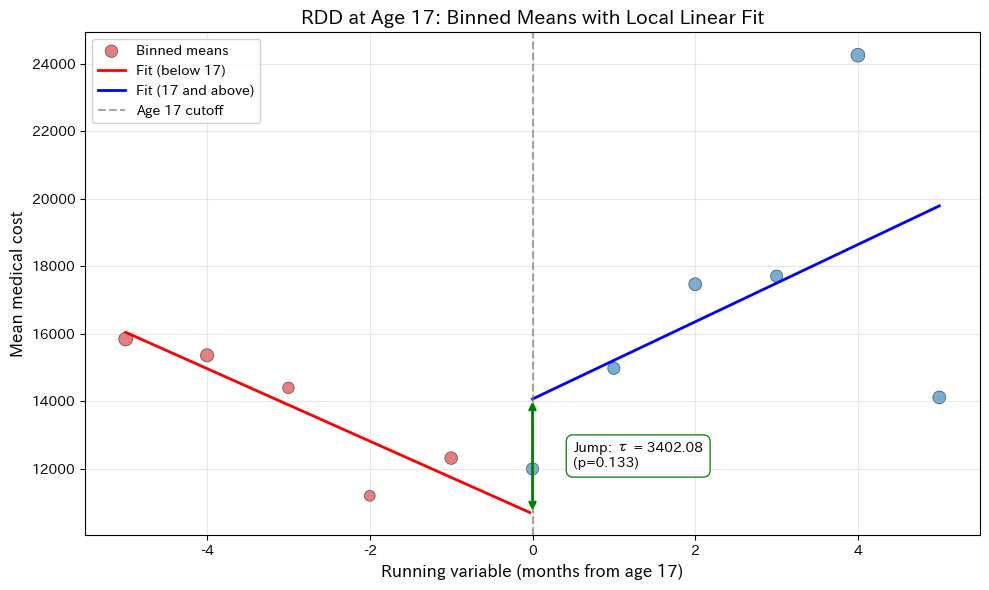


✓ Binned RDD analysis complete. Proceed with rdrobust for robust inference.


In [7]:
# -------- 1) 2022-01断面作成 & 横軸 r_i --------
df = final_df.filter(pl.col("medtreat_yymm") == 202201).select([
    "patient_id", "birth_date", "ika_out_req_amt"
])

# 年齢（月）
age_months = (
    (pl.lit(202201) // 100 - pl.col("birth_date") // 100) * 12
    + (pl.lit(202201) % 100 - pl.col("birth_date") % 100)
).alias("age_months_202201")

df = df.with_columns(age_months)
df = df.with_columns((pl.col("age_months_202201") - 204).alias("r"))  # 17歳=204か月

# 観測ウィンドウ（±12か月 例）
H = 5
df = df.filter(pl.col("r").abs() <= H)

# -------- 2) ビン集約 --------
# 1か月単位でビニング（より細かい分析なら3か月ごとに変更可能）
df = df.with_columns([
    (pl.col("r") // 1).alias("bin1"),
    (pl.col("r") >= 0).cast(pl.Int8).alias("side")
])

# -------- 3) ビン平均（観測点） --------
g = (
    df.group_by("bin1")
      .agg([
          pl.len().alias("n_b"),
          pl.col("ika_out_req_amt").mean().alias("y_bar"),
          pl.col("r").mean().alias("r_bar"),
          pl.col("side").first().alias("side_b")  # ビンの側（firstで十分）
      ])
      .sort("bin1")
)

# Pandasへ
gb = g.to_pandas()

# -------- 4) 片側傾きの線形RDD（ビンWLS） --------
gb["r_minus"] = np.where(gb["r_bar"] < 0, gb["r_bar"], 0.0)
gb["r_plus"]  = np.where(gb["r_bar"] >= 0, gb["r_bar"], 0.0)

import statsmodels.api as sm

X = sm.add_constant(gb[["side_b", "r_minus", "r_plus"]])
w = gb["n_b"]  # 重み＝人数（ビンサイズ）
y = gb["y_bar"]

wls_model = sm.WLS(y, X, weights=w)
res = wls_model.fit(cov_type="HC1")  # ロバストSE
print("\n" + "="*60)
print("Binned WLS Regression Results")
print("="*60)
print(res.summary())

# 効果の解釈：ジャンプ推定量 tau = coef["side_b"]
tau = res.params["side_b"]
tau_se = res.bse["side_b"]
tau_pval = res.pvalues["side_b"]

print("\n" + "="*60)
print(f"RDD Treatment Effect (Jump at cutoff):")
print(f"  Estimate (tau): {tau:.2f}")
print(f"  Std Error:      {tau_se:.2f}")
print(f"  p-value:        {tau_pval:.4f}")
print(f"  95% CI:         [{res.conf_int().loc['side_b', 0]:.2f}, {res.conf_int().loc['side_b', 1]:.2f}]")
print("="*60)

print(f"\nInterpretation: Crossing the age-17 threshold changes medical costs by {tau:.2f} units")

# -------- 5) 可視化：ビン散布図 + 局所線形フィット --------
import matplotlib.pyplot as plt

# 予測関数（局所線形）
b0   = res.params.get("const", 0.0)
tau_ = res.params["side_b"]
b_m  = res.params["r_minus"]
b_p  = res.params["r_plus"]

def yhat_linear(r):
    r = np.asarray(r)
    r_minus = np.minimum(r, 0.0)
    r_plus  = np.maximum(r, 0.0)
    side    = (r >= 0).astype(float)
    return b0 + tau_*side + b_m*r_minus + b_p*r_plus

# プロット用グリッド
r_min, r_max = gb["r_bar"].min(), gb["r_bar"].max()
r_grid = np.linspace(r_min, r_max, 301)

plt.figure(figsize=(10, 6))

# 1) ビン散布図（点サイズはビンサイズに比例）
sizes = 100 * (gb["n_b"] / gb["n_b"].max())
colors = ['#d62728' if r < 0 else '#1f77b4' for r in gb["r_bar"]]
plt.scatter(gb["r_bar"], gb["y_bar"], s=sizes, alpha=0.6,
           c=colors, edgecolor="k", linewidth=0.5, label="Binned means")

# 2) 局所線形のフィット曲線（左右で色分け）
mask_left = r_grid < 0
mask_right = r_grid >= 0
plt.plot(r_grid[mask_left], yhat_linear(r_grid[mask_left]),
        'r-', linewidth=2, label="Fit (below 17)")
plt.plot(r_grid[mask_right], yhat_linear(r_grid[mask_right]),
        'b-', linewidth=2, label="Fit (17 and above)")

# 3) カットオフ線
plt.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label="Age 17 cutoff")

# 4) ジャンプ（tau）の注記
y_at_cutoff = yhat_linear([-0.01, 0.01]).mean()
plt.annotate('', xy=(0, y_at_cutoff + tau_/2), xytext=(0, y_at_cutoff - tau_/2),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
plt.text(0.5, y_at_cutoff,
         f'Jump: τ = {tau_:.2f}\n(p={tau_pval:.3f})',
         ha="left", va="center",
         bbox=dict(facecolor="white", alpha=0.9, boxstyle="round,pad=0.5", edgecolor='green'))

plt.title("RDD at Age 17: Binned Means with Local Linear Fit", fontsize=14, fontweight='bold')
plt.xlabel("Running variable (months from age 17)", fontsize=12)
plt.ylabel("Mean medical cost", fontsize=12)
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Binned RDD analysis complete. Proceed with rdrobust for robust inference.")

コーホートRDD


In [ ]:
# ============================================
# 6) 共変量調整（残差化）RDD：birth_date が yyyymm 形式の場合
# ============================================

# 6-1) 2022-01の個票データを再取得（r, side を付与）
df_ind = final_df.filter(pl.col("medtreat_yymm") == 202201).select([
    "patient_id", "birth_date", "ika_out_req_amt", "medtreat_yymm"
])
# Add age_months first, then use it to calculate r and abs_r
df_ind = (
    df_ind
    .with_columns([
        ((pl.col("medtreat_yymm") // 100 - pl.col("birth_date") // 100) * 12
         + (pl.col("medtreat_yymm") % 100 - pl.col("birth_date") % 100)
        ).alias("age_months")
    ])
    .with_columns([
        (pl.col("age_months") - 204).alias("r"),
        (pl.col("age_months") - 204).abs().alias("abs_r"),
        (pl.col("age_months") - 204 >= 0).cast(pl.Int8).alias("side")
    ])
    .filter(pl.col("abs_r") <= H)  # H は既に定義済み（例：12）
    .drop_nulls(["ika_out_req_amt", "r"])
)

# 6-2) 共変量候補を final_df から（存在するものだけ抽出）
cov_candidates = [
    "sex_type_nm", "annual_salary_rank",	"business_type"
]
present_covs = [c for c in cov_candidates if c in final_df.columns]

if len(present_covs) > 0:
    df_cov = final_df.filter(pl.col("medtreat_yymm") == 202201).select(
        ["patient_id"] + present_covs
    ).unique(subset=["patient_id"])  # 患者単位でユニーク化
    df_ind = df_ind.join(df_cov, on="patient_id", how="left")

# 6-3) Pandasへ変換（残差化のため）
pdf_ind = df_ind.to_pandas()

# 6-4) 共変量で y を残差化（ANCOVA的前処理）
y_col = "ika_out_req_amt"
cov_terms = []

if len(present_covs) > 0:
    for c in present_covs:
        if pd.api.types.is_numeric_dtype(pdf_ind[c]):
            cov_terms.append(f"{c}")
        else:
            cov_terms.append(f"C({c})")

# 月情報を補助的にダミー化（例：季節調整）
if "medtreat_yymm" in pdf_ind.columns:
    try:
        pdf_ind["month_num"] = pdf_ind["medtreat_yymm"].astype(str).str[4:6].astype(int)
        cov_terms.append("C(month_num)")
    except Exception:
        pass

# 残差化実行
if len(cov_terms) > 0:
    fml = y_col + " ~ " + " + ".join(cov_terms)
    ols = sm.OLS.from_formula(fml, data=pdf_ind).fit()
    pdf_ind["y_resid"] = ols.resid
else:
    pdf_ind["y_resid"] = pdf_ind[y_col].astype(float)

# 6-5) 残差を用いたビンWLS（同設計）
pdf_ind["bin2"] = (pdf_ind["r"] // 2).astype(int)

gb_adj = (
    pdf_ind.groupby("bin2", as_index=False)
           .agg(
               n_b=("patient_id", "size"),
               y_bar=("y_resid", "mean"),
               r_bar=("r", "mean"),
               side_b=("side", "first")
           )
           .sort_values("bin2")
           .reset_index(drop=True)
)

# 6-6) 共変量調整後の局所線形RDD（ビンWLS）
gb_adj["r_minus"] = np.where(gb_adj["r_bar"] < 0, gb_adj["r_bar"], 0.0)
gb_adj["r_plus"]  = np.where(gb_adj["r_bar"] >= 0, gb_adj["r_bar"], 0.0)

X_adj = sm.add_constant(gb_adj[["side_b", "r_minus", "r_plus"]])
w_adj = gb_adj["n_b"]
y_adj = gb_adj["y_bar"]

wls_adj = sm.WLS(y_adj, X_adj, weights=w_adj).fit(cov_type="HC1")
print("\n" + "="*60)
print("Binned WLS with Covariate Adjustment (Residualized Outcome)")
print("="*60)
print(wls_adj.summary())

tau_adj     = wls_adj.params["side_b"]
tau_adj_se  = wls_adj.bse["side_b"]
tau_adj_p   = wls_adj.pvalues["side_b"]
ci_low_adj  = wls_adj.conf_int().loc["side_b", 0]
ci_high_adj = wls_adj.conf_int().loc["side_b", 1]

print("\n" + "="*60)
print("Covariate-Adjusted RDD Treatment Effect (Jump at cutoff, residualized y):")
print(f"  Estimate (tau_adj): {tau_adj:.3f}")
print(f"  Std Error:          {tau_adj_se:.3f}")
print(f"  p-value:            {tau_adj_p:.4f}")
print(f"  95% CI:             [{ci_low_adj:.3f}, {ci_high_adj:.3f}]")
print("="*60)

# 任意：クラスタSE（bin単位の相関を考慮）
# Shift bin2 values to be non-negative for clustering
min_bin2 = gb_adj["bin2"].min()
shifted_bin2 = gb_adj["bin2"] - min_bin2

wls_adj_cl = sm.WLS(y_adj, X_adj, weights=w_adj).fit(
    cov_type="cluster", cov_kwds={"groups": shifted_bin2.astype(int)}
)
print("\n--- Cluster-robust (by bin2) ---")
print(wls_adj_cl.summary())
print("tau_adj (clustered) =", wls_adj_cl.params['side_b'],
      "SE =", wls_adj_cl.bse['side_b'],
      "p =", wls_adj_cl.pvalues['side_b'])


Binned WLS with Covariate Adjustment (Residualized Outcome)
                            WLS Regression Results                            
Dep. Variable:                  y_bar   R-squared:                       0.978
Model:                            WLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     56.80
Date:                Wed, 05 Nov 2025   Prob (F-statistic):             0.0174
Time:                        07:10:59   Log-Likelihood:                -44.304
No. Observations:                   6   AIC:                             96.61
Df Residuals:                       2   BIC:                             95.77
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.



===== (Optional) Local Quadratic WLS (HC1) =====
                            WLS Regression Results                            
Dep. Variable:                  y_bar   R-squared:                       0.654
Model:                            WLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     4.628
Date:                Wed, 05 Nov 2025   Prob (F-statistic):             0.0590
Time:                        07:11:03   Log-Likelihood:                -99.769
No. Observations:                  11   AIC:                             211.5
Df Residuals:                       5   BIC:                             213.9
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

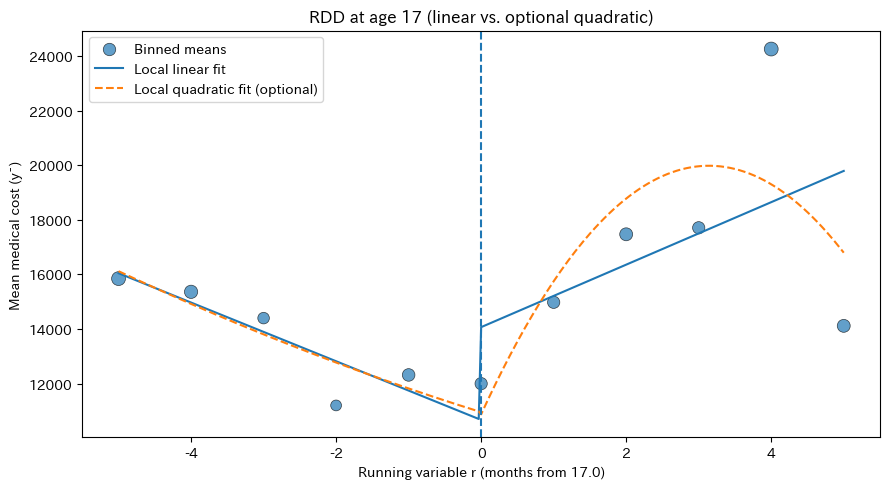

In [ ]:
# ============================
# (Optional) 局所二次 近似の追加
# ============================
RUN_QUADRATIC = True  # ← optional。Falseにすればスキップ

if RUN_QUADRATIC:
    # 左右で二次項を分ける（r<0 と r>=0）
    gb["r2_minus"] = np.where(gb["r_bar"] < 0, gb["r_bar"]**2, 0.0)
    gb["r2_plus"]  = np.where(gb["r_bar"] >= 0, gb["r_bar"]**2, 0.0)

    X2 = sm.add_constant(gb[["side_b","r_minus","r_plus","r2_minus","r2_plus"]])
    w  = gb["n_b"]
    y  = gb["y_bar"]

    wls_q = sm.WLS(y, X2, weights=w).fit(cov_type="HC1")  # ロバストSE
    print("\n===== (Optional) Local Quadratic WLS (HC1) =====")
    print(wls_q.summary())

    # ジャンプ推定値（side_b係数は二次でも同じ解釈）
    tau_q = wls_q.params["side_b"]
    print({"tau_level_quadratic": float(tau_q)})

    # 曲率（r2_minus と r2_plus）の同時有意性：ロバスト Wald 検定
    # 注: cov_type='HC1' の共分散を用いた Wald
    wald_res = wls_q.wald_test("r2_minus = 0, r2_plus = 0")
    print("\n[Wald test] H0: r2_minus = r2_plus = 0  →  p-value =", float(wald_res.pvalue))

    # 線形 vs 二次の情報量基準（比較用）
    try:
        print({"AIC_linear": float(res.aic), "BIC_linear": float(res.bic),
               "AIC_quadratic": float(wls_q.aic), "BIC_quadratic": float(wls_q.bic)})
    except Exception:
        pass

    # （任意）可視化用のフィット値を作る（ビン中心点でのフィット）
    gb["yhat_quad"] = wls_q.predict(X2)

    # -----------------------------
# （任意）二次近似のフィットも重ね描き
# 先ほど追加した RUN_QUADRATIC / wls_q が存在する場合のみ描画
# -----------------------------
try:
    if RUN_QUADRATIC and ('wls_q' in globals() or 'wls_q' in locals()):
        # 予測関数（局所二次）
        b0q   = wls_q.params.get("const", 0.0)
        tau_q = wls_q.params["side_b"]
        bm_q  = wls_q.params["r_minus"]; bp_q  = wls_q.params["r_plus"]
        b2m_q = wls_q.params["r2_minus"]; b2p_q = wls_q.params["r2_plus"]

        def yhat_quad(r):
            r = np.asarray(r)
            r_minus = np.minimum(r, 0.0)
            r_plus  = np.maximum(r, 0.0)
            side    = (r >= 0).astype(float)
            r2_minus = np.where(r < 0, r**2, 0.0)
            r2_plus  = np.where(r >= 0, r**2, 0.0)
            return (b0q + tau_q*side + bm_q*r_minus + bp_q*r_plus
                    + b2m_q*r2_minus + b2p_q*r2_plus)

        plt.figure(figsize=(9,5))
        plt.scatter(gb["r_bar"], gb["y_bar"], s=sizes, alpha=0.7, edgecolor="k", linewidth=0.5, label="Binned means")
        plt.plot(r_grid, yhat_linear(r_grid), label="Local linear fit")
        plt.plot(r_grid, yhat_quad(r_grid), linestyle="--", label="Local quadratic fit (optional)")
        plt.axvline(0, linestyle="--", linewidth=1.5)
        plt.title("RDD at age 17 (linear vs. optional quadratic)")
        plt.xlabel("Running variable r (months from 17.0)")
        plt.ylabel("Mean medical cost (ȳ)")
        plt.legend()
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("(Optional quadratic plot skipped):", e)




ModuleNotFoundError: No module named 'rddensity'



```
# これはコードとして書式設定されます
```

## RDD Models ノンパラ推定


In [ ]:
# ============================================
# CCT法: rdrobust（ノンパラRDD）フルコード
#  - 前提: df に "r"（カットオフからの距離; 0が閾値）, "ika_out_req_amt" がある
#  - df は Polars でも Pandas でもOK（自動で処理）
#  - 帯域幅は rdrobust に任せ、fit.bws から表示
#  - Robust Bias-Corrected (RBC) 推論を安全に抽出
# ============================================

# 1) パッケージの読み込み・用意
from rdrobust import rdrobust, rdplot
# 2) データ取り出し（Polars / Pandas どちらでも可）
def to_pandas_two_cols(df_like, xcol: str, ycol: str):
    """
    df_like が Polars でも Pandas でも、(x, y) を欠損なしの np.ndarray で返す。
    """
    try:
        import polars as pl  # 存在チェック
        if isinstance(df_like, pl.DataFrame):
            dat = (
                df_like.select([xcol, ycol])
                      .drop_nulls()
                      .to_pandas()
            )
        else:
            # Pandas と仮定
            dat = df_like[[xcol, ycol]].dropna().copy()
    except Exception:
        # Pandas のみの場合
        dat = df_like[[xcol, ycol]].dropna().copy()

    x = dat[xcol].astype(float).to_numpy()
    y = dat[ycol].astype(float).to_numpy()
    return x, y

# 3) RBC（Robust Bias-Corrected）系の行・要素を安全に抜き出す小ユーティリティ
def _get_row_index(arr_like, preferred_label: str, fallback_index: int):
    """
    arr_like が pandas Series/DataFrame / numpy array / list など、何でも来る前提で
    行ラベルに preferred_label（例: 'Robust'）があればそこを使い、
    なければ fallback_index を使う。
    """
    try:
        import pandas as pd
        if isinstance(arr_like, (pd.Series, pd.DataFrame)):
            # 行名に 'Robust' 等があればそれを優先
            if preferred_label in arr_like.index:
                return preferred_label
    except Exception:
        pass
    return fallback_index  # 数値インデックス

def _safe_pick(arr_like, row_sel, col_sel=None):
    """
    arr_like から [row_sel, col_sel] を安全に取り出す。
    - row_sel が文字列 -> ラベルで抜く（Series/DataFrameの場合）
    - row_sel が int    -> 位置で抜く
    """
    try:
        import pandas as pd
        if isinstance(arr_like, pd.DataFrame):
            if isinstance(row_sel, str):
                return arr_like.loc[row_sel].iloc[col_sel] if col_sel is not None else arr_like.loc[row_sel]
            else:
                return arr_like.iloc[row_sel, col_sel] if col_sel is not None else arr_like.iloc[row_sel]
        elif isinstance(arr_like, pd.Series):
            if isinstance(row_sel, str):
                return arr_like.loc[row_sel]
            else:
                return arr_like.iloc[row_sel]
    except Exception:
        pass

    # numpy や list の場合
    arr = np.asarray(arr_like)
    if col_sel is None:
        return arr[row_sel]
    return arr[row_sel, col_sel]

# 4) メイン：RDD推定
def run_cct_rdd(
    df_like,
    xcol="r",
    ycol="ika_out_req_amt",
    cutoff=0.0,
    use_log=False,
    kernel="uniform",
    p=1
):
    # --- データ整形 ---
    x, y = to_pandas_two_cols(df_like, xcol, ycol)

    print("\n" + "="*70)
    print("NONPARAMETRIC RDD ANALYSIS using rdrobust (Calonico-Cattaneo-Titiunik)")
    print("="*70)

    print(f"\nSample size: N = {len(x):,}")
    print(f"Running variable range: [{np.nanmin(x):.4f}, {np.nanmax(x):.4f}]")
    print(f"Observations below cutoff: {(x < cutoff).sum():,}")
    print(f"Observations above cutoff: {(x >= cutoff).sum():,}")

    # --- ログ仕様（任意） ---
    if use_log:
        eps = 1e-6
        y = np.log(y + eps)
        print("\n⚠ Using log-transformed outcome")

    # --- 推定（帯域幅は rdrobust にお任せ：自動選択）---
    print("\n[Step] Estimation with automatic bandwidth selection...")
    fit = rdrobust(
        y, x,
        c=cutoff,
        p=p,
        kernel=kernel
        # h, b を渡さない → 内部で最適化
    )

    # --- 帯域幅の表示（fit.bws を信頼）---
    #   bws は DataFrame/array など環境差があるので、安全に取り出して表示
    print("\n" + "-"*70)
    print("Selected bandwidths (from fit.bws):")
    try:
        bws = fit.bws
        # できるだけ見やすくダンプ
        print(bws)
    except Exception:
        print("  (Could not display bws table; use print(fit) to inspect.)")

    # --- 推定表（print）---
    print("\n" + "="*70)
    print("FULL OUTPUT (verbatim):")
    print("="*70)
    print(fit)

    # --- RBCに基づく推定値・SE・CI・p値の抽出（環境差に耐える）---
    # CCT慣例：
    #   ・点推定は Bias-Corrected（BC）
    #   ・不確実性は Robust（RBC）
    coef_arr = getattr(fit, "coef", None)
    se_arr   = getattr(fit, "se",   None)
    ci_arr   = getattr(fit, "ci",   None)
    pv_arr   = getattr(fit, "pv",   None)

    # 行名があれば優先（'Bias-Corrected', 'Robust' 等）。なければ数値index想定：
    #   coef の行1=BC, se/ci/pv の行2=Robust の慣例にフォールバック
    bc_row = _get_row_index(coef_arr, preferred_label="Bias-Corrected", fallback_index=1)
    rb_row = _get_row_index(se_arr,   preferred_label="Robust",         fallback_index=2)

    # 列は通常：左・右の差の列が1列目（0列目は?）実装差あり得るため安全側で 1列目(=列 index 1) を優先
    # うまく行かない場合は 0 列にフォールバック
    def _safe_col_pick(two_dim, prefer=1):
        try:
            val = _safe_pick(two_dim, rb_row if two_dim is se_arr or two_dim is ci_arr or two_dim is pv_arr else bc_row, prefer)
            return val
        except Exception:
            return _safe_pick(two_dim, rb_row if two_dim is se_arr or two_dim is ci_arr or two_dim is pv_arr else bc_row, 0)

    point_bc = _safe_col_pick(coef_arr, 1)  # BCの点推定
    se_rbc   = _safe_col_pick(se_arr,   1)  # Robust SE
    # CI と p 値は配列形状が [rows, 2] / [rows, ?] のことが多いので個別対応
    try:
        ci_low  = _safe_pick(ci_arr, rb_row, 0)
        ci_high = _safe_pick(ci_arr, rb_row, 1)
    except Exception:
        # 列入替フォールバック
        ci_low  = _safe_pick(ci_arr, rb_row, 0)
        ci_high = _safe_pick(ci_arr, rb_row, -1)
    try:
        pval = float(_safe_col_pick(pv_arr, 1))
    except Exception:
        # 1 列目が無理なら 0 列目
        pval = float(_safe_col_pick(pv_arr, 0))

    # 有意性スター
    if pval < 0.01:
        sig = "***"
        sig_text = "1%"
    elif pval < 0.05:
        sig = "**"
        sig_text = "5%"
    elif pval < 0.10:
        sig = "*"
        sig_text = "10%"
    else:
        sig = ""
        sig_text = None

    print("\n" + "="*70)
    print("RESULTS: Bias-Corrected estimate with Robust (RBC) inference")
    print("="*70)
    print(f"  Point estimate (Bias-Corrected): {float(point_bc):.6g}")
    print(f"  Robust standard error (RBC):     {float(se_rbc):.6g}")
    print(f"  95% Confidence interval (RBC):   [{float(ci_low):.6g}, {float(ci_high):.6g}]")
    print(f"  p-value (RBC):                   {pval:.4g}")
    if sig_text:
        print(f"  → Statistically significant at {sig_text} level {sig}")

    direction = "increases" if float(point_bc) > 0 else "decreases"
    print(f"\nInterpretation: Crossing the cutoff {direction} the outcome by {abs(float(point_bc)):.6g} {sig}")

    # --- RD Plot（自動ビニング、最小引数で互換性重視）---
    print("\n[Step] Generating RD plot (rdplot)...")
    try:
        # 引数名の互換性問題を避けるため必要最小限に留める
        _ = rdplot(y, x, c=cutoff, binselect="es", kernel=kernel, p=p)
        print("✓ RD plot generated.")
    except Exception as e:
        print(f"⚠ rdplot encountered an issue: {e}")
        print("  (Plotting dependenciesや引数互換の問題が原因のことがあります。推定結果自体は有効です)")

    print("\n" + "="*70)
    print("✓ Nonparametric RDD analysis complete")
    print("="*70)

    return fit  # 後で fit を使いたい場合のため返す

 #5) 例：実行
fit = run_cct_rdd(df, xcol="r", ycol="ika_out_req_amt", cutoff=0.0, use_log=False, kernel="uniform", p=1)




NONPARAMETRIC RDD ANALYSIS using rdrobust (Calonico-Cattaneo-Titiunik)

Sample size: N = 210
Running variable range: [-5.0000, 5.0000]
Observations below cutoff: 93
Observations above cutoff: 117

[Step] Estimation with automatic bandwidth selection...
Mass points detected in the running variable.
Mass points detected in the running variable.


LinAlgError: Matrix is not positive definite

密度検定、共変量バランス検定など

In [ ]:
# ============================================
# 7) 密度検定 (McCrary Test, Cattaneo et al. 2020)
# ============================================

!pip install rddensity
from rddensity import rddensity, rdplotdensity
import pandas as pd
import numpy as np

# running variable（年齢-17歳）
x = df["r"].to_pandas()  # Convert Polars to Pandas Series
# x = df["r"].to_pandas().to_numpy()  # Original line


print("\n" + "="*70)
print("Density Discontinuity Test at Cutoff (McCrary, 2008 / Cattaneo et al. 2020)")
print("="*70)

# 実行
dens = rddensity(x, c=0.0)

# 結果表示
print(dens)

# グラフ（密度プロット＋局所線形フィット）
rdplotdensity(dens, x, c=0.0)

print("\n✓ Density test complete. Check if the density is continuous at the cutoff.")


Density Discontinuity Test at Cutoff (McCrary, 2008 / Cattaneo et al. 2020)


ValueError: ('Lengths must match to compare', (529,), (1,))

In [ ]:
print(fit.bws)          # 採用された帯域幅（左/右の h, b）
# 例: h_l, h_r, b_l, b_r が表示される実装もあります


        left      right
h   9.404181   9.404181
b  14.909387  14.909387


 ### Extra Plotting